In [1]:
import numpy as np
import pandas as pd

# Load Data

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('../data/cleaned_review_data.csv', 
                 parse_dates=['SubmissionTime', 'FirstSubmissionTime', 'LastSubmissionTime'], 
                 low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1364686 entries, 0 to 1364685
Data columns (total 24 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   pd_id                 1364686 non-null  object        
 1   brand                 1364686 non-null  object        
 2   Name                  1364686 non-null  object        
 3   Description           1364686 non-null  object        
 4   AverageOverallRating  1364686 non-null  float64       
 5   love_count            1364686 non-null  float64       
 6   reviews_count         1364686 non-null  float64       
 7   Price                 1364686 non-null  float64       
 8   category_1            1364686 non-null  object        
 9   category_2            1006831 non-null  object        
 10  category_3            957356 non-null   object        
 11  FirstSubmissionTime   1364686 non-null  datetime64[ns]
 12  LastSubmissionTime    1364686 non-null  da

In [3]:
df['timestamp'] = df['SubmissionTime'].values.astype(np.int64) // 10 ** 9
ratings = df[['AuthorId', 'pd_id', 'Rating', 'timestamp']]
ratings.sample(5)

,AuthorId,pd_id,Rating,timestamp
963270,6354605363,P442536,5,1563322175
155877,1531784546,P266800,1,1301318715
459783,2307983470,P210575,5,1489488379
865160,1752107198,P2855,5,1297351643
141057,2218807600,P46017,5,1513888777


In [4]:
ratings['Rating'].value_counts()

5    870316
4    241996
3     99220
1     80546
2     72608
Name: Rating, dtype: int64

In [5]:
pds = df[['pd_id', 'Name', 'category_1']].drop_duplicates()
pds.sample(5)

,pd_id,Name,category_1
743517,P443012,Giving Lyfe Texture Refreshing Styling Spray,Hair
1217986,P38220,Stella,Fragrance
86007,P416055,First Light Priming Filter Face Primer,Makeup
333735,P432657,Extra Matte Ultra Mattifying Primer,Makeup
999645,P376127,CANDY Eau de Parfum,Fragrance


# Fastai CF

In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.collab import *

In [7]:
data = CollabDataBunch.from_df(ratings, 
                               seed=42, 
                               valid_pct=0.2, 
                               user_name='AuthorId', 
                               item_name='pd_id', 
                               rating_name='Rating')

## EmbeddingDotBias Model

In [12]:
learn = collab_learner(data, n_factors=50, y_range=(1, 5), wd=1e-1)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


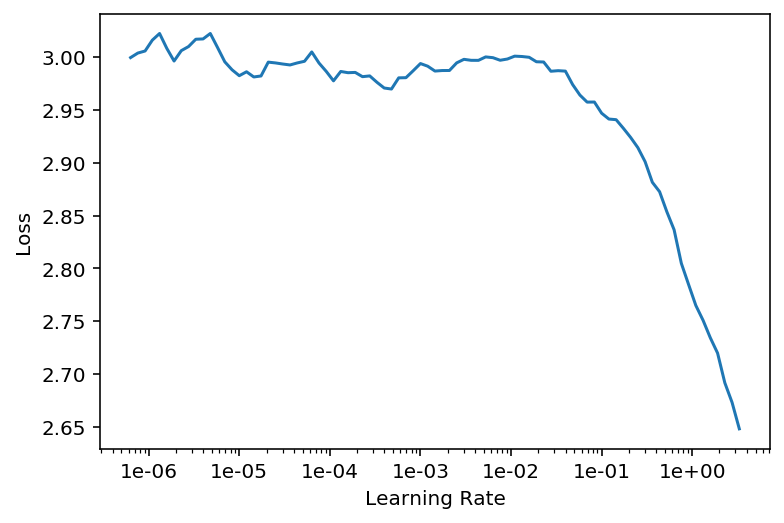

In [13]:
learn.lr_find()
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(5, 1)

epoch,train_loss,valid_loss,time
0,2.018841,1.989568,2:27:45
1,2.135149,2.118508,4:06:17
2,1.915648,1.855183,4:05:47
3,1.676114,1.703966,3:56:57
4,1.458297,1.482833,3:12:41


In [15]:
learn.save('cf-EmbeddingDot-1')

## EmbeddingNN Model

In [16]:
learn = collab_learner(data, 
                       use_nn=True, 
                       emb_szs={'AuthorId': 40, 'pd_id':40}, 
                       layers=[256, 128], 
                       y_range=(1, 5))

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


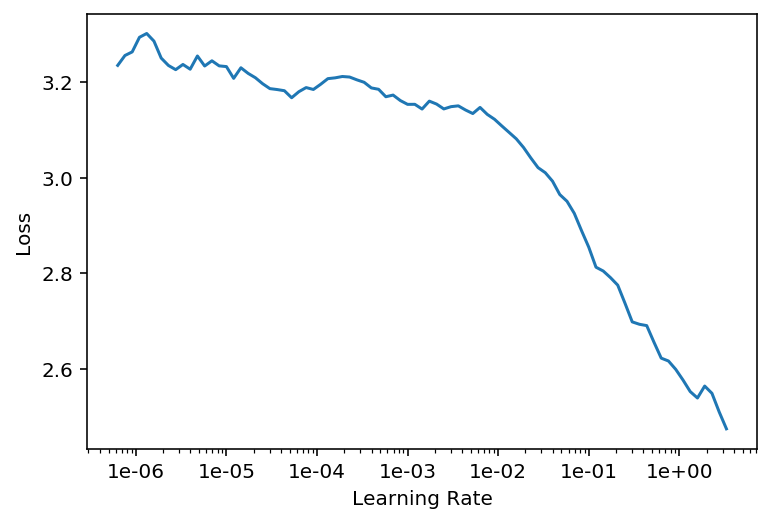

In [17]:
learn.lr_find()
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(5, 1)

epoch,train_loss,valid_loss,time
0,1.912365,1.902893,1:41:55
1,1.936313,1.898555,2:29:21
2,1.876780,1.898555,2:38:44
3,1.829300,1.898555,2:45:16
4,1.317304,1.316617,2:29:21


In [19]:
learn.save('cf-EmbeddingNN-1')

## Interpretation

In [25]:
# load in EmbeddingDotBias model
learn = collab_learner(data, n_factors=50, y_range=(1, 5), wd=1e-1)
learn.load('cf-EmbeddingDot-1')
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(578749, 50)
  (i_weight): Embedding(2295, 50)
  (u_bias): Embedding(578749, 1)
  (i_bias): Embedding(2295, 1)
)

In [26]:
# get top products
g = ratings.groupby('pd_id')['Rating'].count()
top_pds = g.sort_values(ascending=False).index.values[:2000]

# get top users
u = ratings.groupby('AuthorId')['Rating'].count()
top_users = u.sort_values(ascending=False).index.values[:2000]

# create array containing the names of the top products
top_pds_with_name = []
for pd_ in top_pds:
    top_pds_with_name.append(pds[(pds['pd_id']==pd_)]['Name'].values[0])
top_pds_with_name = np.array(top_pds_with_name)

In [27]:
# get top product weights
pd_weights = learn.weight(top_pds, is_item=True)

# get top user weights
user_weights = learn.weight(top_users, is_item=False)

# get top product biases
pd_bias = learn.bias(top_pds, is_item=True)

# get top user biases
user_bias = learn.bias(top_users, is_item=False)


In [28]:
res = user_weights @ pd_weights.T + pd_bias.unsqueeze(-2) + user_bias.unsqueeze(-1)
result = torch.sigmoid(res) * (5-1) + 1

In [29]:
top_10 = np.array([top_pds_with_name[np.argsort(user)[-10:][::-1]] for user in result.numpy()])
result_df = pd.DataFrame(top_10)
result_df.index = top_users
result_df

,0,1,2,3,4,5,6,7,8,9
1126147141,Flowerbomb Mini,Flowerbomb,Jet Lag Mask Mini,Full-On™: Plumping Lip Polish Gloss,24/7 Glide-On Eye Pencil,"Amazing Grace Shampoo, Bath & Shower Gel",Facial Cotton,Liquid Facial Soap,Eye-Conic Multi-Finish Eyeshadow Palette,Blush
1533231934,Facial Cotton,Full-On™: Plumping Lip Polish Gloss,Blush,Flowerbomb Mini,Flowerbomb,Eye-Conic Multi-Finish Eyeshadow Palette,Rosebud Salve,Ultra Repair® Cream Intense Hydration,Intense Therapy Lip Balm SPF 25,24/7 Glide-On Eye Pencil
1000235057,Original Loose Powder Mineral Foundation Broad...,Juicy Tubes Original Lip Gloss 20 Birthday Con...,All Nighter Long-Lasting Makeup Setting Spray ...,All Nighter Long-Lasting Makeup Setting Spray,All Nighter Long-Lasting Makeup Setting Spray ...,Blush,Alpha Beta® Extra Strength Daily Peel,Full-On™: Plumping Lip Cream Gloss,Sugar Lip Balm Sunscreen SPF 15,Viva La Juicy
5309062776,Jet Lag Mask Mini,Flowerbomb Mini,Jet Lag Mask,"Amazing Grace Shampoo, Bath & Shower Gel",Flowerbomb,24/7 Glide-On Eye Pencil,Liquid Facial Soap,KUSH High Volume Mascara,Mini Brazilian Bum Bum Cream,SUPERMUD® Charcoal Instant Treatment Mask
1040369429,Blush,Facial Cotton,Original Loose Powder Mineral Foundation Broad...,Full-On™: Plumping Lip Polish Gloss,Intense Therapy Lip Balm SPF 25,Eye-Conic Multi-Finish Eyeshadow Palette,Amazonian Clay 12-Hour Blush,Ultra Repair® Cream Intense Hydration,Bi-Facil Double-Action Eye Makeup Remover,Rosebud Salve
...,...,...,...,...,...,...,...,...,...,...
1312793027,Original Loose Powder Mineral Foundation Broad...,Blush,Facial Cotton,Full-On™: Plumping Lip Polish Gloss,Intense Therapy Lip Balm SPF 25,Eye-Conic Multi-Finish Eyeshadow Palette,Amazonian Clay 12-Hour Blush,Alpha Beta® Extra Strength Daily Peel,Studded Kiss Crème Lipstick OG Lolita,Bi-Facil Double-Action Eye Makeup Remover
1233355078,Jet Lag Mask Mini,Flowerbomb Mini,Flowerbomb,"Amazing Grace Shampoo, Bath & Shower Gel",24/7 Glide-On Eye Pencil,Full-On™: Plumping Lip Polish Gloss,Liquid Facial Soap,Jet Lag Mask,Facial Cotton,Mini Brazilian Bum Bum Cream
2005623913,Facial Cotton,Full-On™: Plumping Lip Polish Gloss,Blush,Flowerbomb Mini,Flowerbomb,Eye-Conic Multi-Finish Eyeshadow Palette,Intense Therapy Lip Balm SPF 25,Rosebud Salve,Ultra Repair® Cream Intense Hydration,24/7 Glide-On Eye Pencil
986576472,Facial Cotton,Full-On™: Plumping Lip Polish Gloss,Blush,Eye-Conic Multi-Finish Eyeshadow Palette,Flowerbomb,Flowerbomb Mini,Intense Therapy Lip Balm SPF 25,Ultra Repair® Cream Intense Hydration,Rosebud Salve,Bi-Facil Double-Action Eye Makeup Remover


In [30]:
top_10_ = np.array([np.sort(user)[-10:][::-1] for user in result.numpy()])
result_df_ = pd.DataFrame(top_10_)
result_df_.index = top_users
result_df_

,0,1,2,3,4,5,6,7,8,9
1126147141,4.806048,4.779794,4.779572,4.763242,4.742363,4.741970,4.731048,4.716889,4.699786,4.677391
1533231934,4.627478,4.625252,4.600120,4.588930,4.580439,4.566939,4.525239,4.523875,4.523691,4.521160
1000235057,4.817780,4.743483,4.702361,4.688555,4.650560,4.598567,4.579232,4.557920,4.535449,4.534083
5309062776,4.994506,4.980643,4.972629,4.965010,4.962045,4.951126,4.949418,4.927596,4.920825,4.916458
1040369429,4.598138,4.589921,4.565938,4.540082,4.506602,4.506198,4.479554,4.473452,4.470031,4.469373
...,...,...,...,...,...,...,...,...,...,...
1312793027,4.535925,4.511010,4.488945,4.412057,4.398044,4.382082,4.374367,4.358592,4.356589,4.352622
1233355078,4.799407,4.782482,4.732614,4.698560,4.683778,4.668229,4.656349,4.632906,4.585175,4.577404
2005623913,4.538821,4.533317,4.508286,4.482602,4.474674,4.464905,4.416180,4.415585,4.414299,4.403385
986576472,4.536937,4.518427,4.517290,4.457787,4.437265,4.434034,4.422261,4.410893,4.410636,4.386035
